# K-nearest neighbors
# Data preparation
## Reading .csv file into Data Frame

In [32]:
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split,KFold, cross_val_score,cross_val_predict,RandomizedSearchCV,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import export_graphviz
from statistics import mean
from subprocess import call
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

%matplotlib inline

pd.options.mode.chained_assignment = None

col_names = ['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info','src_port','dst_port']
data_frame = pd.read_csv("Samples/smallTraffic-_backup.csv",encoding = "ISO-8859-1", header=0, names=col_names)

data_frame.head(20)

,Time,Source,Destination,Protocol,Length,Info,src_port,dst_port
1,0.000000,192.168.3.131,72.14.213.138,HTTP,997,GET /complete/search?client=chrome&hl=en-US&q=...,57011.0,80.0
2,0.029841,72.14.213.138,192.168.3.131,HTTP,440,HTTP/1.1 200 OK (text/javascript),80.0,57011.0
3,0.223883,192.168.3.131,72.14.213.102,TCP,66,55950 > 80 [SYN] Seq=0 Win=8192 Len=0 MSS=14...,55950.0,80.0
4,0.229423,192.168.3.131,72.14.213.138,TCP,54,57011 > 80 [ACK] Seq=944 Ack=387 Win=16192 L...,57011.0,80.0
5,0.242649,72.14.213.102,192.168.3.131,TCP,66,"80 > 55950 [SYN, ACK] Seq=0 Ack=1 Win=5720 L...",80.0,55950.0
6,0.242696,192.168.3.131,72.14.213.102,TCP,54,55950 > 80 [ACK] Seq=1 Ack=1 Win=65780 Len=0,55950.0,80.0
7,0.243050,192.168.3.131,72.14.213.102,HTTP,998,GET /complete/search?client=chrome&hl=en-US&q=...,55950.0,80.0
8,0.262981,192.168.3.131,72.14.213.102,TCP,54,"55950 > 80 [FIN, ACK] Seq=945 Ack=1 Win=6578...",55950.0,80.0
9,0.264074,72.14.213.102,192.168.3.131,TCP,60,80 > 55950 [ACK] Seq=1 Ack=945 Win=7616 Len=0,80.0,55950.0
10,0.276671,72.14.213.102,192.168.3.131,HTTP,541,HTTP/1.1 200 OK (text/javascript),80.0,55950.0


# Data cleaning
## Set source port and destination port of ICMP to (-1) becouse of NaN occurance

In [33]:
icmp = ['ICMP']
temp_df = data_frame['Protocol'].copy(deep=True)
data_frame.src_port[temp_df.isin(icmp)] = -1 #0
data_frame.dst_port[temp_df.isin(icmp)] = -1 #0

data_frame.loc[(data_frame['src_port'] == -1) & (data_frame['dst_port'] == -1)].head(10)

,Time,Source,Destination,Protocol,Length,Info,src_port,dst_port
5960,116.676994,10.0.2.2,10.0.2.15,ICMP,202,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
5961,116.677060,10.0.2.2,10.0.2.15,ICMP,203,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
6035,117.265243,10.0.2.2,10.0.2.15,ICMP,202,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
6036,117.265322,10.0.2.2,10.0.2.15,ICMP,203,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
6133,117.812397,10.0.2.2,10.0.2.15,ICMP,202,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
6134,117.812489,10.0.2.2,10.0.2.15,ICMP,203,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
6142,118.248598,10.0.2.2,10.0.2.15,ICMP,202,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
6143,118.248695,10.0.2.2,10.0.2.15,ICMP,203,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
6164,118.702913,10.0.2.2,10.0.2.15,ICMP,202,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0
6165,118.702988,10.0.2.2,10.0.2.15,ICMP,203,Time-to-live exceeded (Time to live exceeded i...,-1.0,-1.0


# Each ICMP packet has been succesfully changed

In [34]:
data_frame.loc[(data_frame['src_port'] != -1) & (data_frame['dst_port'] != -1) & (data_frame['Protocol'] == "ICMP")]

,Time,Source,Destination,Protocol,Length,Info,src_port,dst_port


# Data encoding
## We simplify our data from complex types into simple numbers
## Example:  "HTTP" -> 3
## This operation will speed up our algorithms

In [35]:
label_enc = preprocessing.LabelEncoder()

src_encoded=label_enc.fit_transform(data_frame['Source'])
dst_encoded=label_enc.fit_transform(data_frame['Destination'])

src_port_encoded=label_enc.fit_transform(data_frame['src_port'])
dst_port_encoded=label_enc.fit_transform(data_frame['dst_port'])

len_encoded = label_enc.fit_transform(data_frame['Length'])

protocol_encoded=label_enc.fit_transform(data_frame['Protocol'])

features=list(zip(src_encoded,dst_encoded,src_port_encoded,dst_port_encoded,len_encoded))

# Searching for best K factor in a loop



Time: 28.3517484664917 seconds


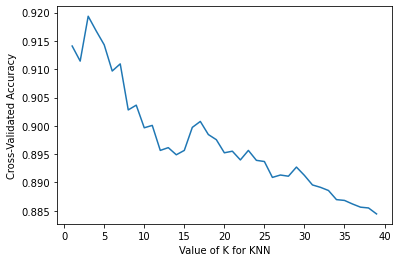

In [36]:
start_time = time.time()

X = features
y = protocol_encoded
k_fold = KFold(n_splits=10)

K_range = range(1, 40)
K_scores = []

for i in K_range:
    knnClf = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knnClf, X, y, cv=k_fold, n_jobs=1,scoring='accuracy')#cv = 10?
    K_scores.append(scores.mean())
    
plt.plot(K_range, K_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

print("\n\nTime: %s seconds" % (time.time() - start_time))

# More efficient parameter tuning using GridSearchCV

In [37]:
knnClf = KNeighborsClassifier()
K_range = list(range(1, 40))

param_grid = dict(n_neighbors=K_range)
print(param_grid)

grid = GridSearchCV(knnClf, param_grid, cv=k_fold, scoring='accuracy') #cv = 10

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]}


# Fit data to tuned classifier

In [41]:
start_time = time.time()

grid.fit(X, y)

print("\n\nTime: %s seconds" % (time.time() - start_time))



Time: 28.477742433547974 seconds


# Evaluation metrics from the gridsearch

In [39]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035351,0.000897,0.032201,0.000599,1,{'n_neighbors': 1},0.948143,0.972651,0.953717,0.756662,0.942496,0.967041,0.967742,0.935484,0.910940,0.786115,0.914099,0.073673,4
1,0.035499,0.000919,0.033200,0.000399,2,{'n_neighbors': 2},0.948143,0.982468,0.949509,0.744039,0.935484,0.967742,0.971950,0.932679,0.909537,0.772791,0.911434,0.079342,5
2,0.035001,0.000774,0.033500,0.000671,3,{'n_neighbors': 3},0.950946,0.979663,0.950210,0.746844,0.927770,0.972651,0.967742,0.934081,0.922861,0.840813,0.919358,0.068555,1
3,0.034999,0.000775,0.033800,0.000401,4,{'n_neighbors': 4},0.952348,0.981066,0.951613,0.739130,0.915849,0.969144,0.966339,0.927770,0.915147,0.849229,0.916764,0.069323,2
4,0.035300,0.000900,0.034183,0.000367,5,{'n_neighbors': 5},0.949544,0.981767,0.946704,0.744039,0.910238,0.969144,0.966339,0.909537,0.917251,0.848527,0.914309,0.067766,3
5,0.035101,0.000945,0.034193,0.000741,6,{'n_neighbors': 6},0.944639,0.981767,0.949509,0.740533,0.887097,0.965638,0.966339,0.906732,0.916550,0.838008,0.909681,0.069757,7
6,0.035184,0.000893,0.034461,0.000728,7,{'n_neighbors': 7},0.946041,0.980365,0.948808,0.740533,0.881487,0.967041,0.967742,0.906031,0.916550,0.854839,0.910943,0.068534,6
7,0.035398,0.001019,0.034600,0.000801,8,{'n_neighbors': 8},0.950245,0.979663,0.946704,0.737027,0.849229,0.962132,0.967041,0.904628,0.912342,0.819074,0.902809,0.074289,9
8,0.035399,0.000799,0.034700,0.000782,9,{'n_neighbors': 9},0.952348,0.978962,0.943899,0.735624,0.845722,0.960028,0.965638,0.897616,0.918654,0.838008,0.903650,0.072693,8
9,0.035299,0.000900,0.035201,0.000873,10,{'n_neighbors': 10},0.946741,0.978962,0.945302,0.730014,0.845021,0.958626,0.962132,0.895512,0.913745,0.820477,0.899653,0.074979,13


# Best accuracy score

In [42]:
print("Score: {}".format(grid.best_score_))
print("N neighbors: {}".format(grid.best_params_))
print("Best estimator: {}".format(grid.best_estimator_))

Score: 0.9193582786787766
N neighbors: {'n_neighbors': 3}
Best estimator: KNeighborsClassifier(n_neighbors=3)
